# 2021년 2학기 금융시장의 빅데이터 분석 중간고사(담당교수: 박석진)

1. (10점) 은경, 소연, 우진, 그리고 석진은 서울의 한 카페에서 모임을 가졌다. 모임 중에, 다음의 음식들을 주문했다. 음료는 각자 계산하고, 디저트류는 4명이 동일하게 나눠서 계산하기로 했을 때 각자 얼마씩 계산을 해야하는지 python 코드를 작성하여 구하시오 (단, for 문을 포함한 코드를 작성해야함).

    - 음료
        - 아메리카노(4200원): 은경, 소연, 석진 (총 3잔)
        - 말차라떼(5000원): 우진 (총 1잔)
    - 디저트
        - 무화과바치케(6,500원): (총 1개)
        - 브라우니(4,500원): (총 1개)

In [1]:
americano = 4200 ; malcha = 5000; noflowerfruit=6500; browny = 4500 #가격선언
beverage = [americano, malcha] #음료분류
dessert = [noflowerfruit, browny]#디저트분류

people_Bevareage = {"은경":americano,"소연":americano,"우진":americano,"석진":malcha} #사람과 그사람이 먹은 음료 매칭
people_List = list(people_Bevareage.keys()) #사람들 이름으로 구성된 리스트생성

print("각자 얼마씩 내야하는가?")
for i in people_List: #사람리스트에서 사람을 i로 불러옴
    bev_price = people_Bevareage[i] #해당사람이 먹은 음료의 가격 책정 
    des_price = 0 
    for j in dessert:  #디저트 가격 합산하는 루프
        des_price += j   
    des_price /= len(people_List) #합산된 디저트 가격을 N분의 1해서 인당 디저트 가격 책정
    
    print("{} : {}원".format(i,int(bev_price+des_price)))  #그사람이 내야할 돈은 인당 디저트가격 + 개인이 먹은 음료

각자 얼마씩 내야하는가?
은경 : 6950원
소연 : 6950원
우진 : 6950원
석진 : 7750원


2. (총 30점) 지금부터 여러분들은 자금을 받아 펀드를 운용하는 펀드매니저입니다. 어느날, 한 고객이 찾아와 돈을 맡기면서 다음의 조건에 맞는 포트폴리오를 구성해달라고 합니다. 이를 바탕으로 다음의 질문에 답하시오.

    - 다음의 주식들로 포트폴리오를 구성: 삼성전자, 엔씨소프트, SK하이닉스, 카카오, 네이버
    - 2019.1.1 ~ 2020.1.1의 일별데이터를 사용.
    - 수익률은 ${P_t - P_{t-1}}\over{P_{t-1}}$로 구함. 이때, $t$는 daily frequency를 의미함.
    - 위험자산 중 60%는 삼성전자 주식으로 구성(무위험자산은 고려 x).
    - 포트폴리오에 포함되는 모든 자산의 가중치는 0 ~ 100% 사이.
    - 위험 한 단위 대비 기대수익률이 가장 높은 포트폴리오를 구성.

In [2]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader.data as web
import seaborn as sns; sns.set()
import scipy.optimize as opt

- 2-1. (10점) 삼성전자의 가중치는 60%로 고정하고, 나머지 가중치들을 무작위로 부여한 random portfolio를 5,000개 생성해 위험자산들로만 이루어진 mean-variance frontier를 도출하시오.

In [3]:
data = pd.DataFrame() 
for code in ['005930','036570' ,'000660', '035720', '035420'] :  #data불러오기
    data = pd.concat([data,web.DataReader(code, 'naver', start='2019-01-01', end='2020-01-01')['Close'].apply(int)], axis=1)

data.columns =['삼성전자','엔씨소프트' ,'SK하이닉스', '카카오', '네이버']   #column이름 할당  
noa = len(data.columns) #noa 변수에 column개수 할당

In [4]:
ret = data.pct_change().dropna()  #전일 대비 수익률로 구성된 dataframe생성

In [5]:
def ret_std(weight, ret): 
    port_mean = np.sum(weight * ret.mean() *250) #포트폴리오 수익률의 평균구하기
    port_var = np.dot(weight.T, np.dot(ret.cov()*250, weight)) #포트폴리오 수익률의 분산구하기
    port_std = np.sqrt(port_var) #분산에 루트를 취해 표준편차 구한 모습
    return port_mean, port_std #평균수익률과 표준편차 반환

def statistics(weights, rf=0): # statistics 선언(포트폴리오 수익률, volatility, sharpe ratio반환)
    weights = np.array(weights) #weight를 array변환
    pret = np.sum(ret.mean() * weights) * 252 - rf  #포트폴리오 수익률 생성
    pvol = np.sqrt(np.dot(weights.T, np.dot(ret.cov() * 252, weights))) #포트폴리오 volatility 생성
    return np.array([pret, pvol, pret / pvol])  #포트폴리오 수익률, volatility, sharpe ratio반환

def min_func_sharpe(weights, rf=0): #sharpe ratio 반환하는 함수
    return -statistics(weights, rf)[2]# -sharpe ratio 반환

def min_func_volatility(weights): #volatility 반환하는 함수
    return statistics(weights)[1] **2  #volatility^2 반환

In [6]:
port_rets = []
port_std = []

for w in range(5000): #삼성전자 비중을 60%로 고정한 상태에서 랜덤하게 나머지 비중을 부여하여 5000개 포트만들기
    weight = np.random.random(noa-1) #종목개수만큼 랜덤한 숫자를 부여함.(랜덤하게 비중 부여하는 작업)
    weight /= np.sum(weight)*2.5 #포트전체비율에서 40%를 4종목이 랜덤하게 나누어 가지도록 부여
    samsung = [0.6] #samsung에는 전체포트비중의 60%부여
    samsung.extend(list(weight)) #삼성 비중0.6과 랜덤하게 부여된 4비중을 하나로 합침
    weight = np.array(samsung) #그 합친 것을 list에서 array로 변경
    mu, sig = ret_std(weight, ret) #ret_std함수로 수익률의 평균과 표준편차 반환
    port_rets.append(mu) #아까 생성한 ret 리스트에 수익률 평균 append
    port_std.append(sig) #아까 생성한 std 리스트에 수익률 표준편차 append

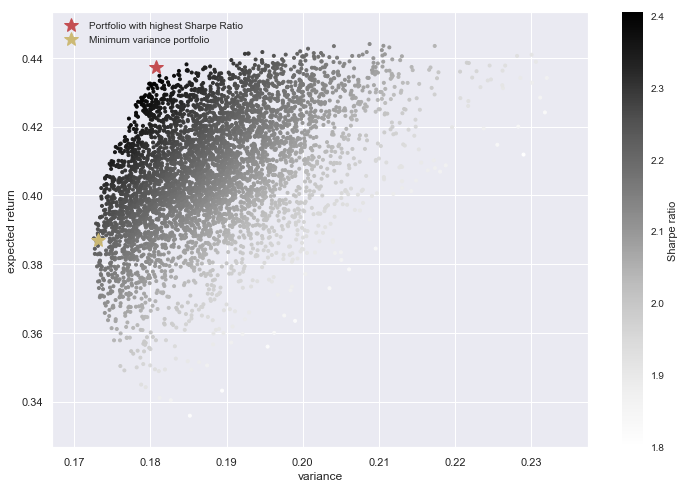

In [7]:
#다음은 최적화 함수에 들어가는 argument들을 모아놓은 것임
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})  #가중치의 합이 1이되도록(100%)가 되도록 제약
bnds = ((0.6,0.6), (0, 0.4), (0, 0.4), (0, 0.4), (0, 0.4))   #삼성의 가중치를 0.6으로 고정하고 나머지는 0.4중에서 나누어가지도록 설정
k = noa * [1. / noa,] # initial guess 

#다음은 -sharpe ratio를 최소화하는 작업임(sharpe ratio 최대화)
opts = opt.minimize(min_func_sharpe, k, method='SLSQP',
                       bounds=bnds, constraints=cons)
#다음은 volatility^2를 최소화하는 작업임
optv = opt.minimize(min_func_volatility, k, method='SLSQP',
                       bounds=bnds, constraints=cons)

plt.figure(figsize=(12, 8))  #그림 사이즈 가로 12 세로8
plt.scatter(port_std, port_rets, #x축에 포트폴리오 표준편차, y축에 평균 수익률을 점(.)으로 표시
            c=np.array(port_rets) / np.array(port_std), marker='.', cmap = 'Greys')#  sr을 좌측에 하양,회색의 cmap으로 표시
            # random portfolio composition
    
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0], #sharpe ratio가 가장 높은 port를 빨간 별로 표시(marker size = 15)
         'r*', markersize=15.0, label = 'Portfolio with highest Sharpe Ratio') #라벨링 'Portfolio with highest Sharpe Ratio'
            # portfolio with highest Sharpe ratio
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],#variance가 가장 낮은 port를 노란 별로 표시(marker size = 15)
         'y*', markersize=15.0, label = 'Minimum variance portfolio') #라벨링 'Minimum variance portfolio'
            # minimum variance portfolio

plt.style.use('seaborn') #seaborn style사용
plt.legend() #상단에 범례 출력
plt.grid(True) # 격자 생성
plt.xlabel('variance') #x축에 라벨링 'variance'  
plt.ylabel('expected return')  #y축에 라벨링 'expected return' 
plt.colorbar(label='Sharpe ratio') #colorbar에 라벨링 'Sharpe ratio'

- 2-2. (10점) Risk-free rate이 0.02 일때, 무위험자산까지 포함한 mean-variance frontier를 도출하고 최적 포트폴리오의 가중치(각 종목별로) 및 최적 포트폴리오의 annualized sharpe-ratio를 구하시오 (1년을 252일로 계산).

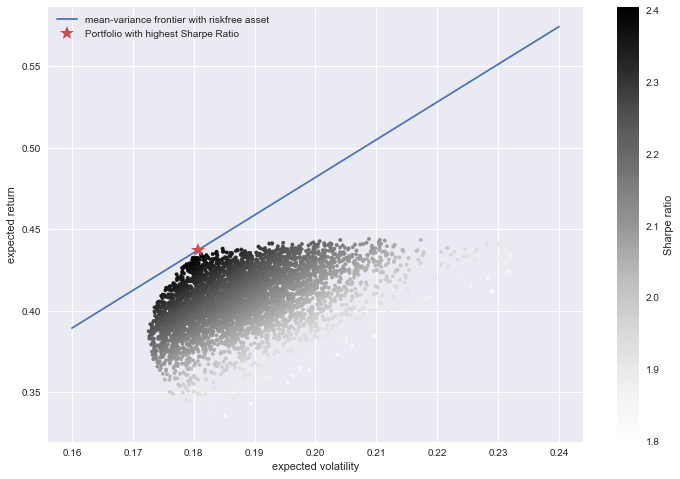

In [8]:
rf = 0.02  #risk free asset 수익률 0.02할당
slope = (statistics(opts['x'])[0] - rf) / statistics(opts['x'])[1] #mean variance frontier의 기울기 구하기
x =  np.linspace(0.16,0.24,5000) #0.16부터 0.24까지 일정간격으로 5000개 x 생성
y = [x*slope + rf for x in np.linspace(0.16,0.24,5000)]#mean variance frontier의 y값들 설정(x에 기울기 곱하고 rf더한 값들)

plt.figure(figsize=(12, 8))  #그림 사이즈 가로 12 세로8
plt.scatter(port_std, port_rets,  #x축에 포트폴리오 표준편차, y축에 평균 수익률을 점(.)으로 표시
            c=np.array(port_rets) / np.array(port_std), marker='.',cmap = 'Greys') #  sr을 좌측에 하양,회색의 cmap으로 표시  

plt.plot(x,y, label = 'mean-variance frontier with riskfree asset') #mean variance frontier를 그린다. 라벨링은 'mean-variance frontier with riskfree asset'
            # random portfolio composition  
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],#sharpe ratio가 가장 높은 port를 빨간 별로 표시(marker size = 15)
         'r*', markersize=15.0, label = 'Portfolio with highest Sharpe Ratio')#라벨링 'Portfolio with highest Sharpe Ratio'
            # portfolio with highest Sharpe ratio
    
plt.legend() #상단에 범례 출력
plt.grid(True) # 격자 생성
plt.xlabel('expected volatility')#x축에 라벨링 'expected volatility'     
plt.ylabel('expected return') #y축에 라벨링 'expected return'      
plt.colorbar(label='Sharpe ratio') #colorbar에 라벨링 'Sharpe ratio' 

In [9]:
print("Case 2-2") #2-2의 각 종목에 대한 가중치와 annualized sharpe ratio를 출력하는 과정
print()
print('Annualized sharpe ratio : {}'.format(statistics(opts['x'],0.02)[2])) #annualized sharpe ratio를 출력
print()
print("Weight of optimal portfolio")
for i in range(noa):
    print('{}의 가중치 : {:.2f}%'.format(data.columns[i],opts['x'][i]*100)) #각 종목에 대한 가중치 출력

Case 2-2

Annualized sharpe ratio : 2.308975329595399

Weight of optimal portfolio
삼성전자의 가중치 : 60.00%
엔씨소프트의 가중치 : 0.00%
SK하이닉스의 가중치 : 0.00%
카카오의 가중치 : 20.97%
네이버의 가중치 : 19.03%


- 2-3. (10점) 위의 분석들을, 이번에는 '위험자산 중 60%는 삼성전자 주식으로 구성'이라는 조건을 제외하고 다시 진행하고 최적 포트폴리오의 가중치 및 annualized sharpe-ratio를 (2-2)의 것과 비교하시오. 펀드매니저로써 고객에게 어떤 포트폴리오를 추천하겠습니까?

@ 2-1을 재분석한 결과

In [10]:
port_rets = []
port_std = []

for w in range(5000): #삼성전자를 포함한 모든 종목 비중을 랜덤하게 부여하여 5000개 포트만들기
    weight = np.random.random(noa) #종목개수만큼 랜덤한 숫자를 부여함.(랜덤하게 비중 부여하는 작업)
    weight /= np.sum(weight) #개별종목비중을 (랜덤한 숫자/그 숫자들의 합)으로 나타내어 비율로써 부여
    mu, sig = ret_std(weight, ret) #위의 함수로 수익률의 평균과 표준편차 반환
    port_rets.append(mu) #아까 생성한 ret 리스트에 수익률 평균 append
    port_std.append(sig) #아까 생성한 std 리스트에 수익률 표준편차 append

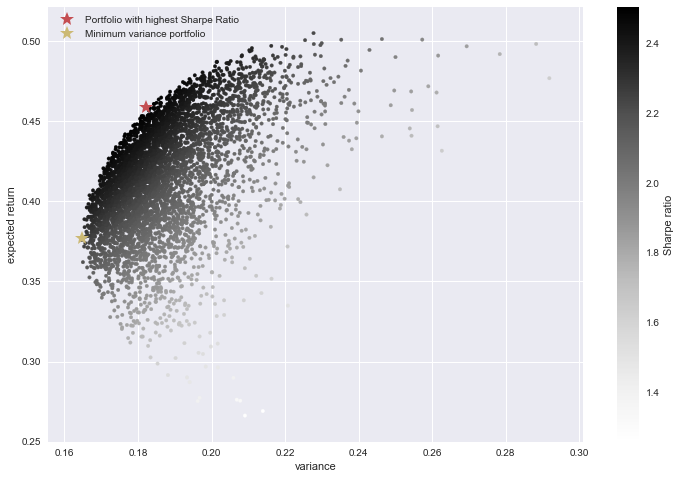

In [11]:
#다음은 최적화 함수에 들어가는 argument들을 모아놓은 것임
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1}) #가중치의 합이 1이되도록(100%)가 되도록 제약
bnds = tuple((0, 1) for x in range(noa)) #각 가중치가 가질 수 있는 값의 범위 설정 0~1
noa * [1. / noa,]  #initial guess

#다음은 -sharpe ratio를 최소화하는 작업임(sharpe ratio 최대화)
opts = opt.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)
#다음은 volatility^2를 최소화하는 작업임
optv = opt.minimize(min_func_volatility, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)

plt.figure(figsize=(12, 8))  #그림 사이즈 가로 12 세로8
plt.scatter(port_std, port_rets, #x축에 포트폴리오 표준편차, y축에 평균 수익률을 점(.)으로 표시
            c=np.array(port_rets) / np.array(port_std), marker='.', cmap = 'Greys')#  sr을 좌측에 하양,회색의 cmap으로 표시
            # random portfolio composition
    
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0], #sharpe ratio가 가장 높은 port를 빨간 별로 표시(marker size = 15)
         'r*', markersize=15.0, label = 'Portfolio with highest Sharpe Ratio') #라벨링 'Portfolio with highest Sharpe Ratio'
            # portfolio with highest Sharpe ratio
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],#variance가 가장 낮은 port를 노란 별로 표시(marker size = 15)
         'y*', markersize=15.0, label = 'Minimum variance portfolio') #라벨링 'Minimum variance portfolio'
            # minimum variance portfolio

plt.style.use('seaborn') #seaborn style사용
plt.legend() #상단에 범례 출력
plt.grid(True) # 격자 생성
plt.xlabel('variance') #x축에 라벨링 'variance'  
plt.ylabel('expected return')  #y축에 라벨링 'expected return' 
plt.colorbar(label='Sharpe ratio') #colorbar에 라벨링 'Sharpe ratio'

@ 2-2를 재분석한 결과

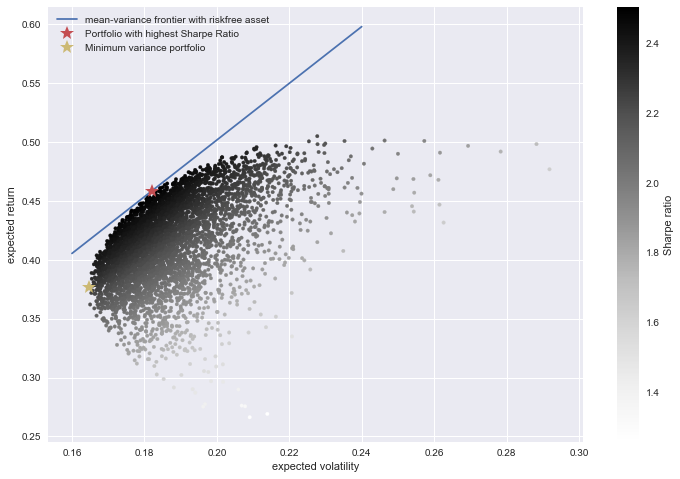

In [12]:
rf = 0.02  #risk free asset 수익률 0.02할당
slope = (statistics(opts['x'])[0] - rf) / statistics(opts['x'])[1] #mean variance frontier의 기울기 구하기
x =  np.linspace(0.16,0.24,5000) #0.16부터 0.24까지 일정간격으로 5000개 x 생성
y = [x*slope + rf for x in np.linspace(0.16,0.24,5000)]#mean variance frontier의 y값들 설정(x에 기울기 곱하고 rf더한 값들)

plt.figure(figsize=(12, 8))  #그림 사이즈 가로 12 세로8
plt.scatter(port_std, port_rets,  #x축에 포트폴리오 표준편차, y축에 평균 수익률을 점(.)으로 표시
            c=np.array(port_rets) / np.array(port_std), marker='.',cmap = 'Greys') #  sr을 좌측에 하양,회색의 cmap으로 표시  

plt.plot(x,y, label = 'mean-variance frontier with riskfree asset') #mean variance frontier를 그린다. 라벨링은 'mean-variance frontier with riskfree asset'
            # random portfolio composition  
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],#sharpe ratio가 가장 높은 port를 빨간 별로 표시(marker size = 15)
         'r*', markersize=15.0, label = 'Portfolio with highest Sharpe Ratio')#라벨링 'Portfolio with highest Sharpe Ratio'
            # portfolio with highest Sharpe ratio
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],#variance가 가장 낮은 port를 노란 별로 표시(marker size = 15)
         'y*', markersize=15.0, label = 'Minimum variance portfolio') #라벨링 'Minimum variance portfolio'
            # minimum variance portfolio
    
plt.legend() #상단에 범례 출력
plt.grid(True) # 격자 생성
plt.xlabel('expected volatility')#x축에 라벨링 'expected volatility'     
plt.ylabel('expected return') #y축에 라벨링 'expected return'      
plt.colorbar(label='Sharpe ratio') #colorbar에 라벨링 'Sharpe ratio' 

In [13]:
print("Case 2-3") #2-3의 각 종목에 대한 가중치와 annualized sharpe ratio를 출력하는 과정
print()
print('Annualized sharpe ratio : {}'.format(statistics(opts['x'],0.02)[2])) #annualized sharpe ratio를 출력
print()
print("Weight of optimal portfolio") 
for i in range(noa):
    print('{}의 가중치 : {:.2f}%'.format(data.columns[i],opts['x'][i]*100)) #각 종목에 대한 가중치 출력
print()
print("2-2와 비교해본 결과 삼성전자의 가중치를 60%로 고정한 포트폴리오는 sharpe ratio가 약 2.3089이지만\n\
삼성전자의 가중치를 60%로 고정하지 않고 구한 2-3의 포트폴리오는 sharpe ratio가 약 2.40899이므로 2-3이 더 높다. ")
print('펀드매니저로서 섬성전자의 비중을 60%로 고정하지 않은 2-3의 포트폴리오를 추천할 것 같다\n\
그 이유는 Sharpe ratio가 더 높기 때문이다') #비교하고 펀드매니저로서 추천

Case 2-3

Annualized sharpe ratio : 2.4089906134033714

Weight of optimal portfolio
삼성전자의 가중치 : 34.64%
엔씨소프트의 가중치 : 0.98%
SK하이닉스의 가중치 : 10.03%
카카오의 가중치 : 29.63%
네이버의 가중치 : 24.72%

2-2와 비교해본 결과 삼성전자의 가중치를 60%로 고정한 포트폴리오는 sharpe ratio가 약 2.3089이지만
삼성전자의 가중치를 60%로 고정하지 않고 구한 2-3의 포트폴리오는 sharpe ratio가 약 2.40899이므로 2-3이 더 높다. 
펀드매니저로서 섬성전자의 비중을 60%로 고정하지 않은 2-3의 포트폴리오를 추천할 것 같다
그 이유는 Sharpe ratio가 더 높기 때문이다
